In [2]:
import ROOT as rt
import uproot
# from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/02
gpu-ibanks-3.hep.caltech.edu  Tue Oct 12 20:54:26 2021  470.57.02
[0] NVIDIA GeForce GTX 1080 | 23'C,   0 % |   741 /  8119 MB | 3042(737M)
[1] NVIDIA GeForce GTX 1080 | 25'C,   0 % |  7687 /  8119 MB | schen7(7683M)
[2] NVIDIA GeForce GTX 1080 | 27'C,   0 % |  7687 /  8119 MB | schen7(7683M)
[3] NVIDIA GeForce GTX 1080 | 23'C,   0 % |  7687 /  8119 MB | schen7(7683M)
[4] NVIDIA GeForce GTX 1080 | 26'C,   0 % |  7687 /  8119 MB | schen7(7683M)
[5] NVIDIA GeForce GTX 1080 | 25'C,   0 % |   727 /  8119 MB | 3012(723M)
[6] NVIDIA GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[7] NVIDIA GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |


In [3]:
def samp_to_df(samp_name):
    file_name = f'ML/DNN_Trees/combine_sequential_DNN/post_ms/{samp_name}_5.root'
    samp_file = uproot.open(file_name)
    samp_array = samp_file['tree'].arrays()
    samp_df = pd.DataFrame(samp_array)
    return samp_df

def data_to_df(samp_name):
    file_name = f'ML/DNN_Trees/combine_sequential_DNN/post_ms/{samp_name}.root'
    samp_file = uproot.open(file_name)
    samp_array = samp_file['tree'].arrays()
    samp_df = pd.DataFrame(samp_array)
    return samp_df

In [4]:
samples = ['sig', 'VBFHToGG', 'VHToGG', 'ttHToGG', 'GluGluHtoGG', 'nonres']
dfs = []
for samp in samples:
    dfs.append(samp_to_df(samp))

data_df = data_to_df('data_result')
data_sideband_df = data_to_df('data_sideband')

In [5]:
cat1_dfs = []
cat2_dfs = []
for df in dfs:
    c1_df = df[df[b'mass_sculpt_cut_sm'] == 1]
    c2_df = df[df[b'mass_sculpt_cut_sm'] == 0]
    cat1_dfs.append(c1_df)
    cat2_dfs.append(c2_df)
    
data_df_cat1 = data_df[data_df[b'mass_sculpt_cut_sm']==1]
data_df_cat2 = data_df[data_df[b'mass_sculpt_cut_sm']==0]

In [ ]:
cut_cat1_dfs = []
cut_cat2_dfs = []


In [6]:
for i in range(len(samples)):
    print(samples[i])
    weight_1 = cat1_dfs[i].loc[:,b'genweight_scale'].values
    weight_2 = cat2_dfs[i].loc[:, b'genweight_scale'].values
    c1_yield = np.sum(weight_1)
    c2_yield = np.sum(weight_2)
    num_event_c1 = weight_1.shape[0]
    num_event_c2 = weight_2.shape[0]
    print(f'Cat 1 Yield: {c1_yield}')
    print(f'Cat 2 Yield: {c2_yield}')
    print(f'Cat 1 #: {num_event_c1}')
    print(f'Cat 2 #: {num_event_c2}')
    print('\n')
    
print('Data')
c1_yield = np.sum(data_df_cat1.loc[:,b'genweight'].values)
c2_yield = np.sum(data_df_cat2.loc[:, b'genweight'].values)
print(f'Cat 1 Yield: {c1_yield}')
print(f'Cat 2 Yield: {c2_yield}')
print('\n')

sig
Cat 1 Yield: 1.7972341161129326
Cat 2 Yield: 0.3630563286953312
Cat 1 #: 19379
Cat 2 #: 3640


VBFHToGG
Cat 1 Yield: 2.0268253899370796
Cat 2 Yield: 28.192944412623266
Cat 1 #: 1524
Cat 2 #: 22418


VHToGG
Cat 1 Yield: 7.34086227204584
Cat 2 Yield: 62.3498116943523
Cat 1 #: 2901
Cat 2 #: 27234


ttHToGG
Cat 1 Yield: 1.3714950166749729
Cat 2 Yield: 5.901805502540929
Cat 1 #: 4883
Cat 2 #: 20925


GluGluHtoGG
Cat 1 Yield: 23.90607990440339
Cat 2 Yield: 380.917905672844
Cat 1 #: 1585
Cat 2 #: 24818


nonres
Cat 1 Yield: 18664.12622897837
Cat 2 Yield: 312947.8696158767
Cat 1 #: 39409
Cat 2 #: 467244


Data
Cat 1 Yield: 30637.0
Cat 2 Yield: 290654.0




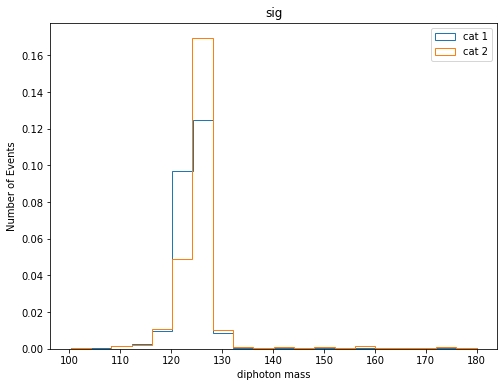

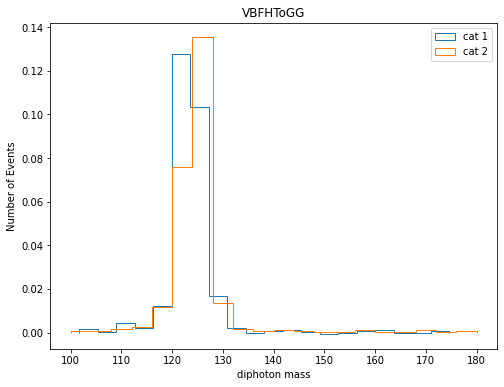

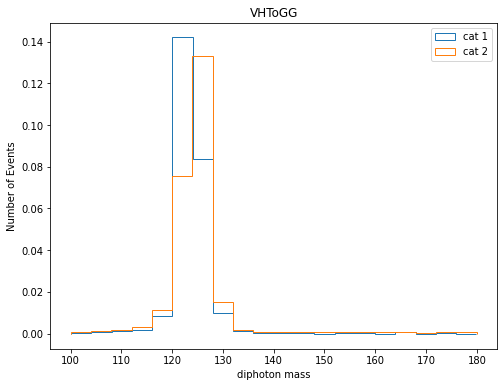

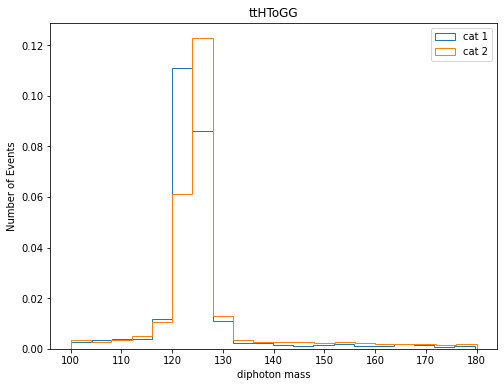

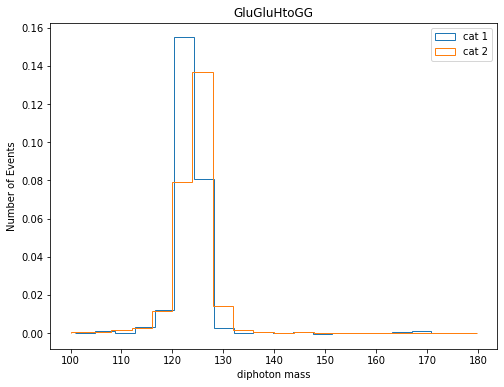

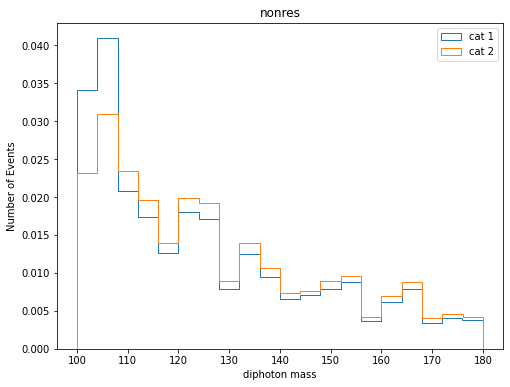

In [10]:
for i in range(len(samples)):
    plt.figure()
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

combine -M AsymptoticLimits -m 125 -n v1 /storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/script/datacards/HHbbgg_datacard.txt --saveWorkspace --saveToys --run blind
